Dataset link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Import all the libraries and load dataset files

In [3]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                       
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image

In [4]:
base_dir = "C:/Users/Joshuaa/OneDrive/Documents/Study/ODL - Mr. Raheem Mafas/Group Assignment/image_dataset"  # Change this to the actual path of the extracted dataset
train_dir = os.path.join(base_dir, 'seg_train')
test_dir = os.path.join(base_dir, 'seg_test')
pred_dir = os.path.join(base_dir, 'seg_pred')

Data Augmentation and Transformation

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',   # Fill gaps
                                   validation_split=0.2)  # Set validation split to 20% 

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data, just rescale


In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(100, 100),   # Resize images to 100x100 pixels
                                                    batch_size=64,            # Load images in batches of 64
                                                    class_mode='categorical', # Labels are one-hot encoded (6 categories)
                                                    subset='training')        # Set as training data

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=(100, 100),   
                                                         batch_size=64,            
                                                         class_mode='categorical', 
                                                         subset='validation')       # Set as validation data

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(100, 100),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [7]:
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

index_to_class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

Exploratory Data Analysis (EDA)

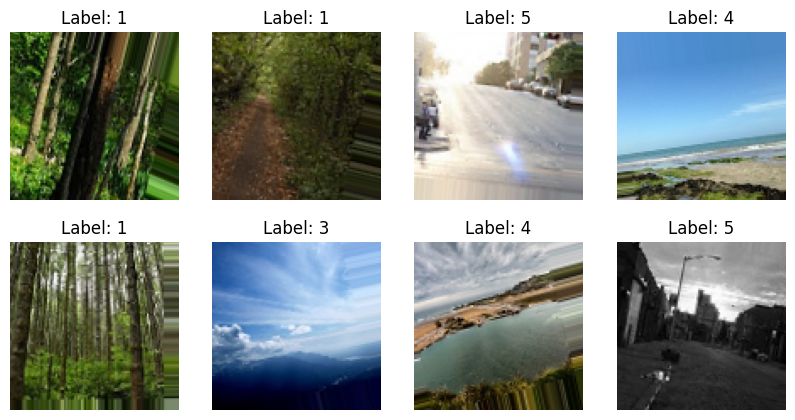

In [8]:
def show_sample(generator):
    sample_batch = next(generator)  # Get a batch of data
    images, labels = sample_batch   # Unpack the images and their corresponding labels
    plt.figure(figsize=(10, 5))
    for i in range(8):  # Show 8 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

show_sample(train_generator)


In [9]:
def check_corrupted_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(subdir, file))
                img.verify()  # Verify that the image can be opened
            except (IOError, SyntaxError) as e:
                print(f"Corrupted image detected: {os.path.join(subdir, file)}")
    print("No corrupted image for ", directory)

check_corrupted_images(train_dir)
check_corrupted_images(test_dir)

No corrupted image for  C:/Users/Joshuaa/OneDrive/Documents/Study/ODL - Mr. Raheem Mafas/Group Assignment/image_dataset\seg_train
No corrupted image for  C:/Users/Joshuaa/OneDrive/Documents/Study/ODL - Mr. Raheem Mafas/Group Assignment/image_dataset\seg_test


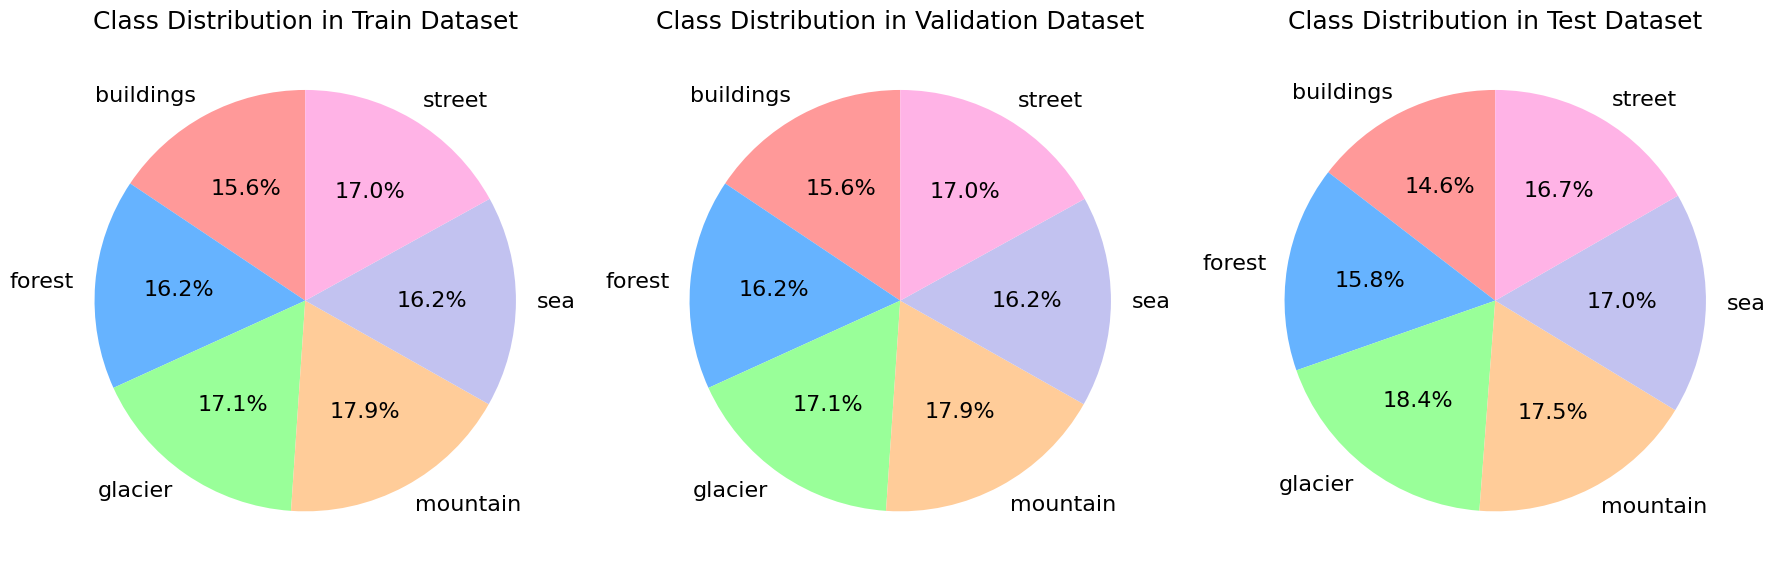

In [10]:
# Count the number of images in each class for a given directory
def count_images_per_class(directory):
    class_counts = {}
    for subdir in os.listdir(directory):
        class_dir = os.path.join(directory, subdir)
        if os.path.isdir(class_dir):
            class_counts[subdir] = len(os.listdir(class_dir))
    return pd.Series(class_counts)

# Get class counts for train, validation, and test datasets
train_class_counts = count_images_per_class(train_dir)
validation_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

# Plot the distribution as pie charts for the train, validation, and test datasets side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train dataset pie chart
train_class_counts.plot(kind='pie', 
                        autopct='%1.1f%%', 
                        startangle=90, 
                        title='Class Distribution in Train Dataset', 
                        ax=axes[0], 
                        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6'],
                        fontsize=16)  # Increase font size for percentage labels
axes[0].set_ylabel('')  # Hide y-axis label for better visualization
axes[0].title.set_fontsize(18)  # Set title font size

# Validation dataset pie chart
validation_class_counts.plot(kind='pie', 
                             autopct='%1.1f%%', 
                             startangle=90, 
                             title='Class Distribution in Validation Dataset', 
                             ax=axes[1], 
                             colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6'],
                             fontsize=16)  # Increase font size for percentage labels
axes[1].set_ylabel('')  # Hide y-axis label for better visualization
axes[1].title.set_fontsize(18)  # Set title font size

# Test dataset pie chart
test_class_counts.plot(kind='pie', 
                       autopct='%1.1f%%', 
                       startangle=90, 
                       title='Class Distribution in Test Dataset', 
                       ax=axes[2], 
                       colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6'],
                       fontsize=16)  # Increase font size for percentage labels
axes[2].set_ylabel('')  # Hide y-axis label for better visualization
axes[2].title.set_fontsize(18)  # Set title font size

plt.tight_layout()  # Adjust layout
plt.show()


In [11]:
# Check image dimensions
sample_batch = next(train_generator)
images, labels = sample_batch

print("Shape of one image:", images[0].shape)
print("Batch shape:", images.shape)


Shape of one image: (100, 100, 3)
Batch shape: (64, 100, 100, 3)


In [12]:
# Check one-hot encoding labels
print("One-hot encoded labels for the first batch:")
print(labels[:5])  # Show the first 5 labels


One-hot encoded labels for the first batch:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


Convolutional Neural Network (CNN) model using Tensorflow/Keras

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

cnn_model = Sequential([
    Input(shape=(100, 100, 3)),
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(100,100,3)),  
    Conv2D(64, kernel_size=(3,3), activation='relu'),  
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),  

    Conv2D(32, kernel_size=(3,3), activation='relu'),  
    Conv2D(32, kernel_size=(3,3), activation='relu'),  
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),  

    Conv2D(16, kernel_size=(3,3), activation='relu'),  
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),  

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    Dropout(0.4), 
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    Dropout(0.4), 

    Dense(6, activation='softmax')
])

c:\Users\Joshuaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
# Compile the model
cnn_model.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [72]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [73]:
# Summary of the model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,798 (686.71 KB)

 Trainable params: 175,798 (686.71 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train the model
history = cnn_model.fit(train_generator, 
                        epochs=20, 
                        validation_data=validation_generator,
                        callbacks=[early_stopping])


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 152s 842ms/step - accuracy: 0.2604 - loss: 1.8200 - val_accuracy: 0.5046 - val_loss: 1.3087
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 146s 823ms/step - accuracy: 0.4755 - loss: 1.3616 - val_accuracy: 0.5681 - val_loss: 1.2500
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 829ms/step - accuracy: 0.5217 - loss: 1.2413 - val_accuracy: 0.5842 - val_loss: 1.1012
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 828ms/step - accuracy: 0.5545 - loss: 1.1661 - val_accuracy: 0.5881 - val_loss: 1.1157
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 832ms/step - accuracy: 0.5615 - loss: 1.1416 - val_accuracy: 0.6238 - val_loss: 1.0288
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 146s 822ms/step - accuracy: 0.5864 - loss: 1.0869 - val_accuracy: 0.6526 - val_loss: 0.9342
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 141s 794ms/step - accuracy: 0.6142 - loss: 1.0356 - val_accuracy: 0.6690 - val_loss: 0.9093
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 799ms/step - accuracy: 0.6498 -

In [61]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7801 - loss: 0.6902
Test Accuracy: 0.7720
Test Loss: 0.7000


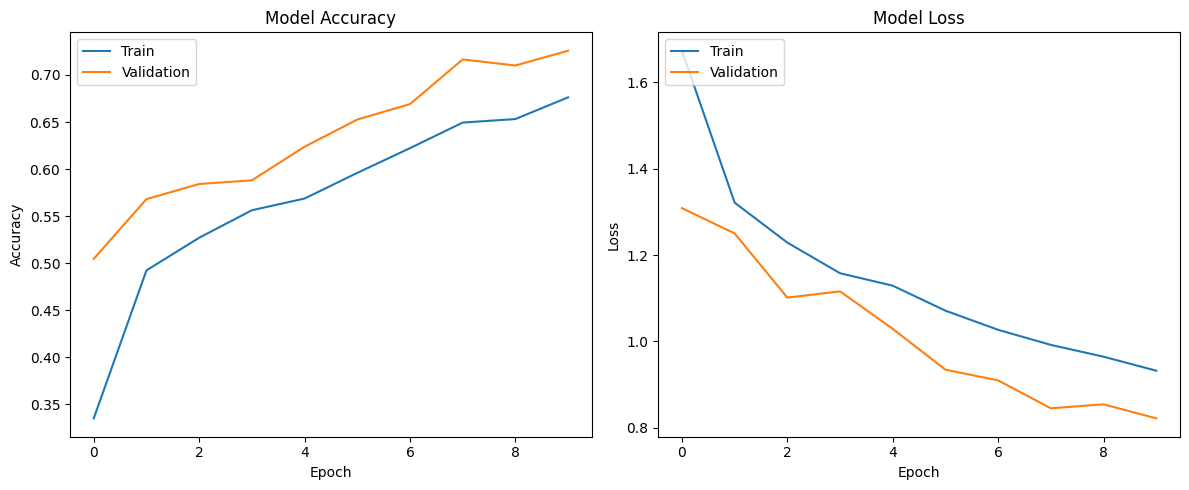

In [89]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Train')
axs[0].plot(history.history['val_accuracy'], label='Validation')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Train')
axs[1].plot(history.history['val_loss'], label='Validation')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [40]:
from keras.models import load_model

cnn_model = load_model('model.keras')

In [41]:
# Get the ground truth labels from the test generator
y_true = test_generator.classes

# Predict the labels for the test dataset
y_pred_prob = cnn_model.predict(test_generator)  # Predict probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels


47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step


In [42]:
y_pred

array([0, 5, 0, ..., 3, 0, 5], dtype=int64)

In [43]:
unique_pred_indices = np.unique(y_pred)
print("Unique predicted class indices:", unique_pred_indices)

Unique predicted class indices: [0 1 2 3 4 5]


In [44]:
y_true

array([0, 0, 0, ..., 5, 5, 5])

In [45]:
# Generate the classification report
class_labels = list(test_generator.class_indices.keys())  # Get class names
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

   buildings       0.78      0.71      0.74       437
      forest       0.95      0.95      0.95       474
     glacier       0.69      0.85      0.76       553
    mountain       0.79      0.60      0.68       525
         sea       0.73      0.69      0.71       510
      street       0.74      0.85      0.79       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



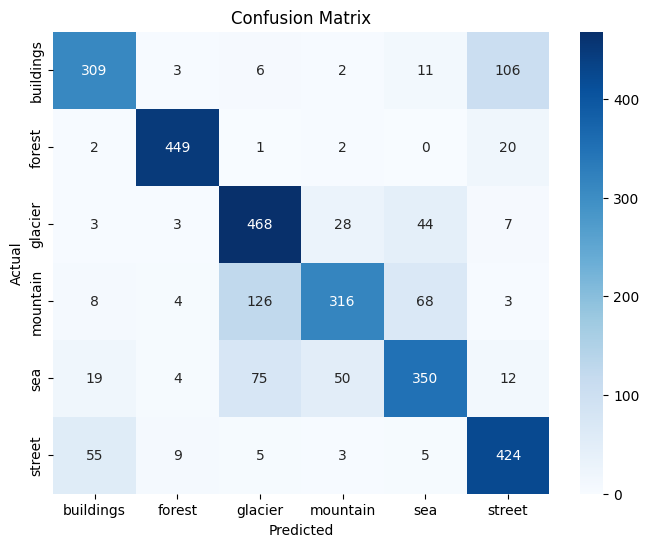

In [46]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=index_to_class.values(), 
            yticklabels=index_to_class.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [64]:
cnn_model.save('model.keras')

In [93]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam  

def build_model(hp):
    cnn_layers = [
        Input(shape=(100, 100, 3)),
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)),

        Conv2D(filters=hp.Int('conv_3_filter', min_value=16, max_value=64, step=16), kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)),

        Flatten(),
        Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(rate=hp.Float('dropout_3', 0.2, 0.5, step=0.1)),
        Dense(6, activation='softmax')
    ]

    model = Sequential(cnn_layers)
    
    model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [94]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='helloworld'
)

In [96]:
tuner.search(train_generator, validation_data=test_generator, 
             epochs=20,
             callbacks=[early_stopping])

Trial 69 Complete [00h 14m 43s]
val_accuracy: 0.8193333148956299

Best val_accuracy So Far: 0.8460000157356262
Total elapsed time: 16h 02m 52s

Search: Running Trial #70

Value             |Best Value So Far |Hyperparameter
32                |96                |conv_1_filter
128               |128               |conv_2_filter
0.2               |0.2               |dropout_1
48                |48                |conv_3_filter
0.4               |0.2               |dropout_2
64                |64                |dense_1_units
0.4               |0.4               |dropout_3
0.00067067        |0.00058942        |learning_rate
17                |50                |tuner/epochs
6                 |17                |tuner/initial_epoch
2                 |3                 |tuner/bracket
1                 |3                 |tuner/round
0053              |0046              |tuner/trial_id

Epoch 7/17
176/176 ━━━━━━━━━━━━━━━━━━━━ 175s 980ms/step - accuracy: 0.6830 - loss: 0.9623 - val_accuracy: 0

KeyboardInterrupt: 

The Hyperparameter Tuning was manually stopped by interrupting the cell, because the new trials are giving similar or lower accuracy, so I decided to just take the best model for now.

and the best model's hyperparameters are as below:

In [97]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print("Best Hyperparameters:")
print("Conv 1 Filters:", best_hyperparameters.get('conv_1_filter'))
print("Conv 2 Filters:", best_hyperparameters.get('conv_2_filter'))
print("Conv 3 Filters:", best_hyperparameters.get('conv_3_filter'))
print("Dense Units:", best_hyperparameters.get('dense_1_units'))
print("Learning Rate:", best_hyperparameters.get('learning_rate'))
print("Dropout 1 Rate:", best_hyperparameters.get('dropout_1'))
print("Dropout 2 Rate:", best_hyperparameters.get('dropout_2'))
print("Dropout 3 Rate:", best_hyperparameters.get('dropout_3'))


Best Hyperparameters:
Conv 1 Filters: 96
Conv 2 Filters: 128
Conv 3 Filters: 48
Dense Units: 64
Learning Rate: 0.0005894233769751197
Dropout 1 Rate: 0.2
Dropout 2 Rate: 0.2
Dropout 3 Rate: 0.4


save the best model

In [107]:
best_model.save('tuned_cnn_model.keras')

In [18]:
from keras.models import load_model

best_model = load_model('tuned_cnn_model.keras')

let's evaluate the model, first look at the accuracy and loss

In [19]:
loss, accuracy = best_model.evaluate(test_generator)
print(f"Validation Accuracy: {accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.8519 - loss: 0.5526
Validation Accuracy: 0.8460000157356262


In [14]:
y_true = test_generator.classes
tuned_y_pred_prob = best_model.predict(test_generator)
tuned_y_pred = np.argmax(tuned_y_pred_prob, axis=1)

class_labels = list(test_generator.class_indices.keys())
tuned_report = classification_report(y_true, tuned_y_pred, target_names=class_labels)

# Print the classification report
print(tuned_report)

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step
              precision    recall  f1-score   support

   buildings       0.82      0.82      0.82       437
      forest       0.95      0.97      0.96       474
     glacier       0.81      0.79      0.80       553
    mountain       0.80      0.79      0.79       525
         sea       0.89      0.85      0.87       510
      street       0.82      0.87      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



[[359   5   2   5   3  63]
 [  3 459   0   2   0  10]
 [  8   4 439  69  22  11]
 [ 10   3  72 414  23   3]
 [ 15   6  27  24 431   7]
 [ 45   5   4   4   7 436]]


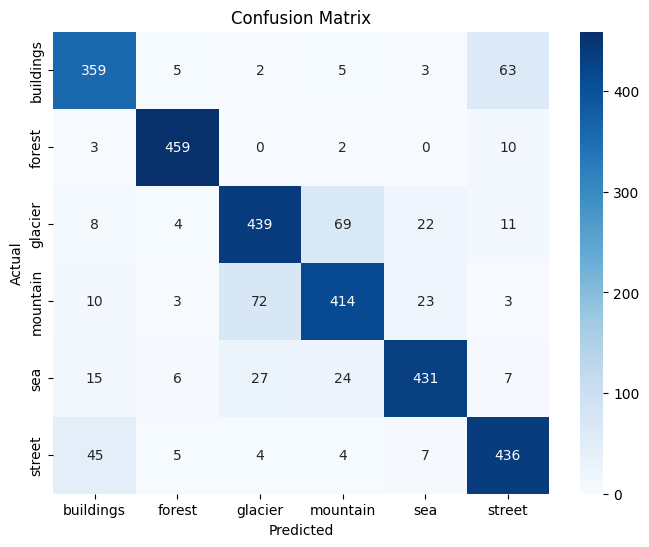

In [15]:
# Compute confusion matrix for tuned model
cm_tuned = confusion_matrix(y_true, tuned_y_pred)

print(cm_tuned)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=index_to_class.values(), 
            yticklabels=index_to_class.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Let's try to predict from unseen data from the seg_pred folder

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = (100, 100)

def load_and_preprocess_images(pred_dir, img_size):
    images = []
    for filename in os.listdir(pred_dir):
        if filename.endswith('.jpg'):  # Check for image file types
            img_path = os.path.join(pred_dir, filename)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)  # Convert the image to a NumPy array
            img_array = img_array / 255.0  # Normalize the image
            images.append(img_array)
    return np.array(images)

# Load and preprocess the images
pred_images = load_and_preprocess_images(pred_dir, img_size)


In [34]:
# Make predictions
predictions = best_model.predict(pred_images)

predicted_classes = np.argmax(predictions, axis=1)  


229/229 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step


In [35]:
print('Prediction Shape is {}'.format(predictions.shape))

Prediction Shape is (7301, 6)


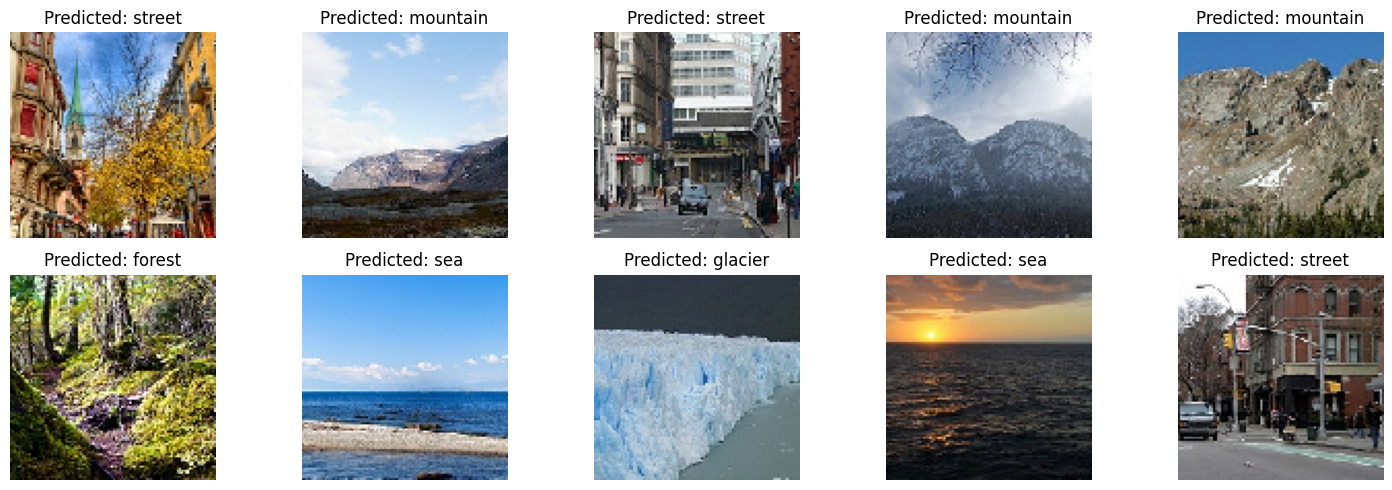

In [39]:
# Plot predictions
def plot_predictions(images, predicted_classes, index_to_class, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {index_to_class[predicted_classes[i]]}")  # Use index_to_class to get class name
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the plotting function with the updated function definition
plot_predictions(pred_images, predicted_classes, index_to_class, num_images=10)
